# Data loading, Preprocess and EDA
---
---

In [118]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Logistiq Prediction") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()


## Load data with spark

In [119]:
df = spark.read.csv("../data/raw/data.csv", header=True, inferSchema=True)

## Analyse Exploratoire des Données (EDA)

In [120]:
df.printSchema()
df.show(5)
print(f"Number of rows: {df.count()}")
df.describe().show()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: double (nullable = true)
 |-- Department Id: integer (nullable = t

* ### Features Selection

In [121]:

df_selected = df.select(
     "Late_delivery_risk",
    
     "Days for shipment (scheduled)",
    "Shipping Mode",
    "order date (DateOrders)",
    
    "Order Item Quantity",
    "Sales",
    "Order Item Total",
    "Order Item Product Price",
    "Order Item Discount Rate",
    
    "Order Country",
    "Order Region",
    "Order State",
    "Market",
    "Customer Country",
    "Latitude",
    "Longitude",
    
    "Category Name",
    "Product Category Id",
    "Department Name",
    "Product Status",
    
     "Customer Segment"
)


for c in df_selected.columns:
    new_c = c.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")
    df_selected = df_selected.withColumnRenamed(c, new_c)


df_selected.printSchema()


root
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Days_for_shipment_scheduled: integer (nullable = true)
 |-- Shipping_Mode: string (nullable = true)
 |-- order_date_DateOrders: string (nullable = true)
 |-- Order_Item_Quantity: integer (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Order_Item_Total: double (nullable = true)
 |-- Order_Item_Product_Price: double (nullable = true)
 |-- Order_Item_Discount_Rate: double (nullable = true)
 |-- Order_Country: string (nullable = true)
 |-- Order_Region: string (nullable = true)
 |-- Order_State: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Customer_Country: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Category_Name: string (nullable = true)
 |-- Product_Category_Id: integer (nullable = true)
 |-- Department_Name: string (nullable = true)
 |-- Product_Status: integer (nullable = true)
 |-- Customer_Segment: string (nullable = true)

* ### Check for missing values

In [122]:
from pyspark.sql.functions import col, isnan, when, count

df_selected.select([count(when(col(c).isNull(), c)).alias(c) for c in df_selected.columns]).show()

+------------------+---------------------------+-------------+---------------------+-------------------+-----+----------------+------------------------+------------------------+-------------+------------+-----------+------+----------------+--------+---------+-------------+-------------------+---------------+--------------+----------------+
|Late_delivery_risk|Days_for_shipment_scheduled|Shipping_Mode|order_date_DateOrders|Order_Item_Quantity|Sales|Order_Item_Total|Order_Item_Product_Price|Order_Item_Discount_Rate|Order_Country|Order_Region|Order_State|Market|Customer_Country|Latitude|Longitude|Category_Name|Product_Category_Id|Department_Name|Product_Status|Customer_Segment|
+------------------+---------------------------+-------------+---------------------+-------------------+-----+----------------+------------------------+------------------------+-------------+------------+-----------+------+----------------+--------+---------+-------------+-------------------+---------------+-------

* ### Counts for categorical features,

In [123]:
categorical_cols = [
    "Shipping_Mode",
    "Customer_Segment",
    "Market",
    "Department_Name",
    "Category_Name",
    "Order_Region",
    "Order_Country",
]

present_categorical_cols = [c for c in categorical_cols if c in df_selected.columns]
# missing = [c for c in categorical_cols if c not in present_categorical_cols]
# if missing:
#     print(f"Warning: these categorical columns are not present in df_selected: {', '.join(missing)}")

for col_name in present_categorical_cols:
    df_selected.groupBy(col_name).count().orderBy("count", ascending=False).show(5)

+--------------+------+
| Shipping_Mode| count|
+--------------+------+
|Standard Class|107752|
|  Second Class| 35216|
|   First Class| 27814|
|      Same Day|  9737|
+--------------+------+

+----------------+-----+
|Customer_Segment|count|
+----------------+-----+
|        Consumer|93504|
|       Corporate|54789|
|     Home Office|32226|
+----------------+-----+

+------------+-----+
|      Market|count|
+------------+-----+
|       LATAM|51594|
|      Europe|50252|
|Pacific Asia|41260|
|        USCA|25799|
|      Africa|11614|
+------------+-----+

+---------------+-----+
|Department_Name|count|
+---------------+-----+
|       Fan Shop|66861|
|        Apparel|48998|
|           Golf|33220|
|       Footwear|14525|
|       Outdoors| 9686|
+---------------+-----+
only showing top 5 rows
+--------------------+-----+
|       Category_Name|count|
+--------------------+-----+
|              Cleats|24551|
|      Men's Footwear|22246|
|     Women's Apparel|21035|
|Indoor/Outdoor Games|19298

* ### Stats for numeric columns

In [124]:
numeric_cols = [
    "Days_for_shipment_scheduled",
    "Order_Item_Quantity",
    "Order_Item_Discount_Rate",
    "Order_Item_Product_Price",
    "Order_Item_Total",
    "Sales",
    "Latitude",
    "Longitude",
]

df_selected.describe(numeric_cols).show()

+-------+---------------------------+-------------------+------------------------+------------------------+------------------+------------------+------------------+------------------+
|summary|Days_for_shipment_scheduled|Order_Item_Quantity|Order_Item_Discount_Rate|Order_Item_Product_Price|  Order_Item_Total|             Sales|          Latitude|         Longitude|
+-------+---------------------------+-------------------+------------------------+------------------------+------------------+------------------+------------------+------------------+
|  count|                     180519|             180519|                  180519|                  180519|            180519|            180519|            180519|            180519|
|   mean|          2.931846509231715|  2.127637533999191|     0.10166819055202563|      141.23254992869786| 183.1076085077815| 203.7720960861678|29.719954662073828| -84.9156746878395|
| stddev|         1.3744492800079773| 1.4534514814226405|     0.0704152153254764

* ### Histogram for numeric columns

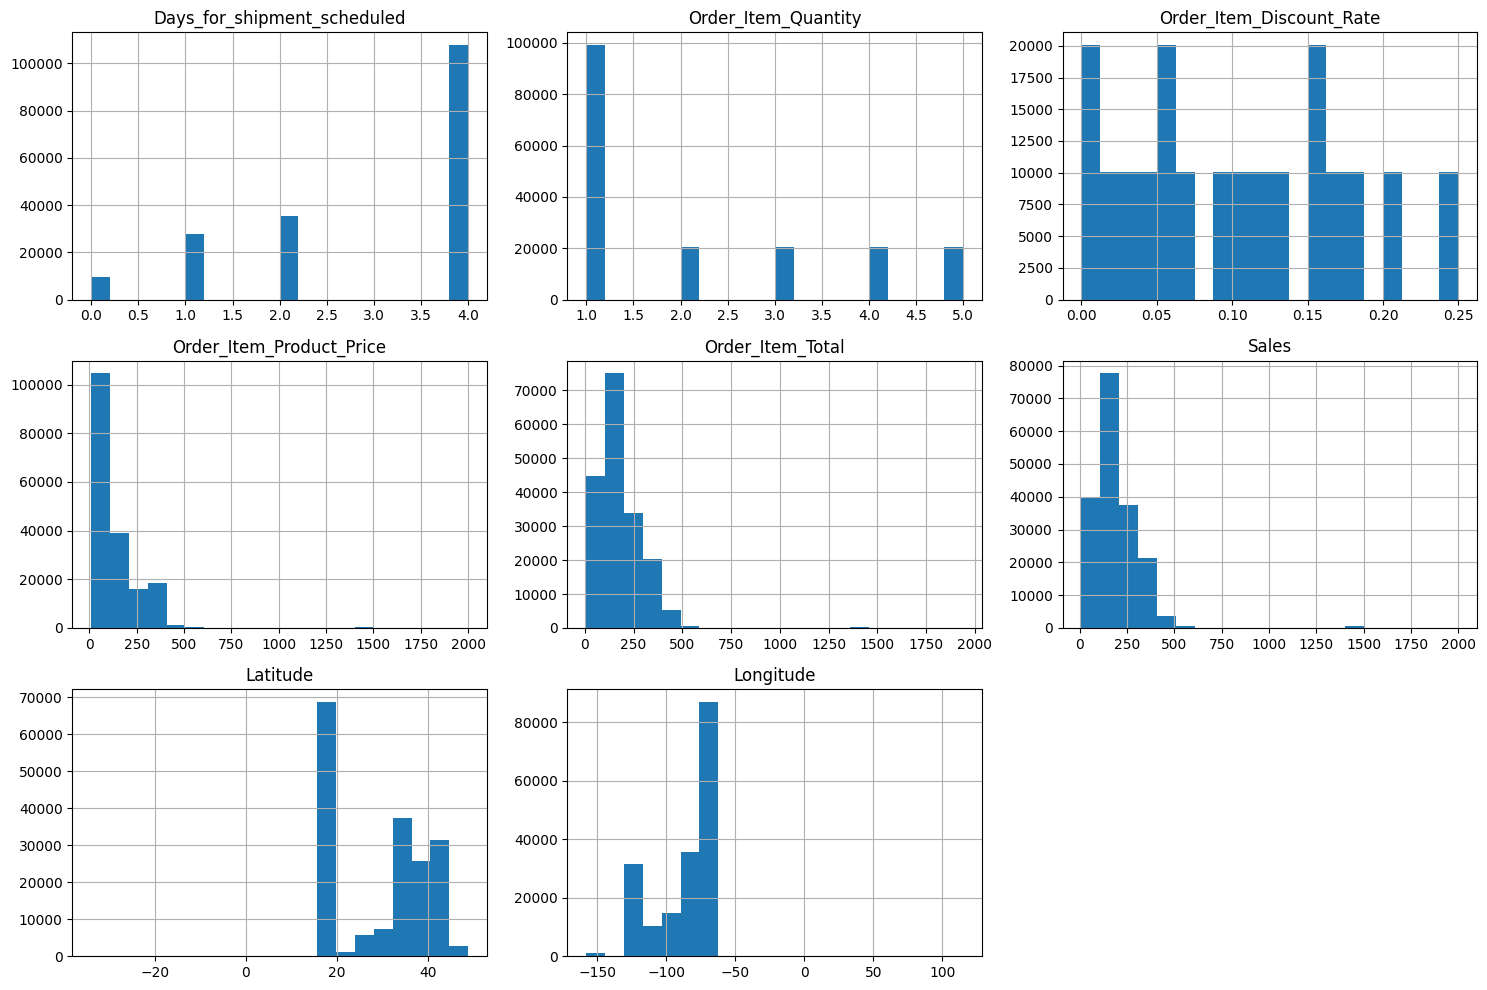

In [125]:
import matplotlib.pyplot as plt

df_selected.select(numeric_cols).toPandas().hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

* ### Explore correlations

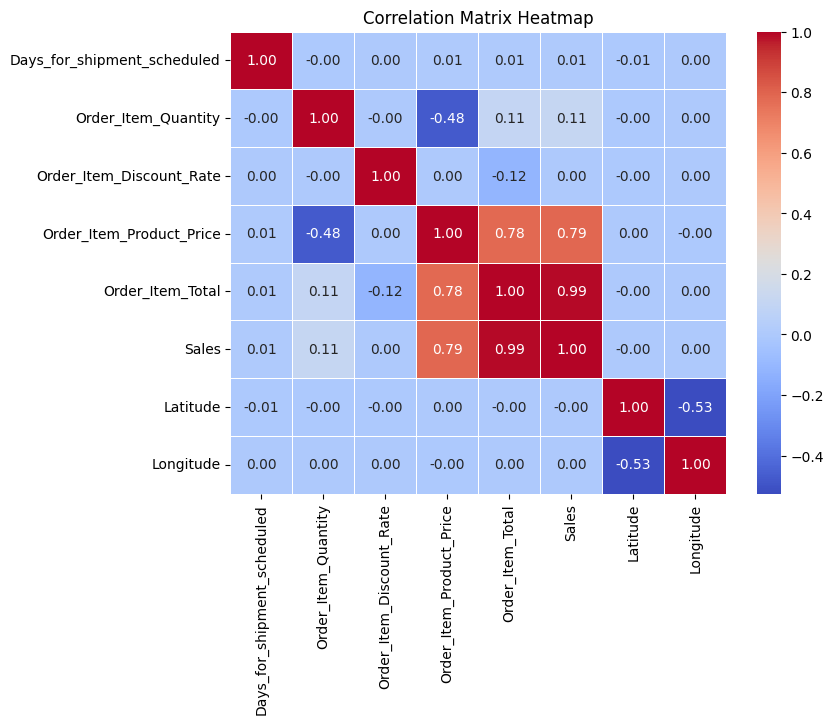

In [126]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_selected.select([col(c).cast(DoubleType()) for c in numeric_cols]))

corr_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

* ### Preprocessing

In [128]:
from pyspark.sql import functions as F

df_featured = df_selected.withColumn(
    "Days_for_shipment_scheduled",
    F.when(F.col("Days_for_shipment_scheduled") == 0, None)
     .otherwise(F.col("Days_for_shipment_scheduled"))
).withColumn(
    "Order_Item_Product_Price",
    F.log1p(F.col("Order_Item_Product_Price"))
).withColumn(
    "Order_Item_Total",
    F.log1p(F.col("Order_Item_Total"))
).withColumn(
    "Sales",
    F.log1p(F.col("Sales"))
).withColumn(
    "Order_Item_Discount_Rate",
    F.when(F.col("Order_Item_Discount_Rate") > 0, 1).otherwise(0)
).withColumn(
    "Order_Item_Quantity",
    F.when(F.col("Order_Item_Quantity") == 1, "single")
     .when(F.col("Order_Item_Quantity") <= 3, "small_batch")
     .otherwise("large_batch")
)

df_featured.show()


+------------------+---------------------------+--------------+---------------------+-------------------+-----------------+-----------------+------------------------+------------------------+-------------+--------------+--------------------+------------+----------------+-----------+------------+--------------+-------------------+---------------+--------------+----------------+
|Late_delivery_risk|Days_for_shipment_scheduled| Shipping_Mode|order_date_DateOrders|Order_Item_Quantity|            Sales| Order_Item_Total|Order_Item_Product_Price|Order_Item_Discount_Rate|Order_Country|  Order_Region|         Order_State|      Market|Customer_Country|   Latitude|   Longitude| Category_Name|Product_Category_Id|Department_Name|Product_Status|Customer_Segment|
+------------------+---------------------------+--------------+---------------------+-------------------+-----------------+-----------------+------------------------+------------------------+-------------+--------------+--------------------